In [74]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
from mlrose_hiive import NeuralNetwork, simulated_annealing, random_hill_climb, NNClassifier, genetic_alg
from sklearn.metrics import accuracy_score
import itertools
    
def load_occupancy_training():
    enc = OrdinalEncoder()
    
    f = open('./datatraining.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def load_occupancy_test():
    enc = OrdinalEncoder()
    
    f = open('./datatest.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def get_best_model(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i

    best_model = scores['estimator'][best_index]
    return best_model

def get_best_score(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i
        
    return best, best_index

# Load and separate Occupancy Training, Validation, and Test Sets

occupancyTrainX, occupancyTrainY = load_occupancy_training()
occTestX, occTestY = load_occupancy_test()

occTrainX, occValidX, occTrainY, occValidY = train_test_split(occupancyTrainX, occupancyTrainY, test_size=.2)

# Load ad separate Digit Training, Validation, and Test Sets

digitData, digitTarget = load_digits(return_X_y=True)
trainDigitX, testDigitX, trainDigitY, testDigitY = train_test_split(digitData, digitTarget, test_size=.2)

trainDigitX, validDigitX, trainDigitY, validDigitY = train_test_split(trainDigitX, trainDigitY, test_size=.2, shuffle=True)




In [75]:
# Learning Curve plotting function

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")


MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(2, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
0.6361111111111111
0.6354166666666666


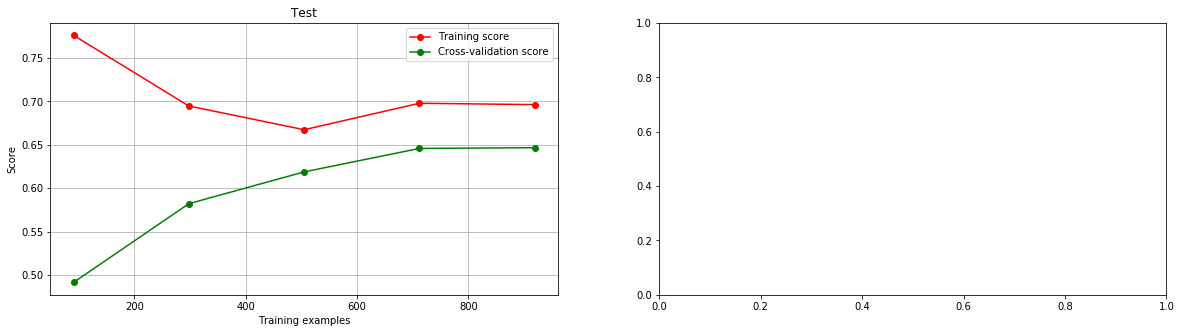

In [52]:
# Neural Networks

# nn = MLPClassifier()
# nn.fit(trainDigitX, trainDigitY)
# print(nn)
# plot_learning_curve(nn, "Neural Network Training", trainDigitX, trainDigitY)

# Create Parameter Dict for GridSearch

params = {
    'activation': 'logistic',
    'max_iter': 2500,
    'random_state': 0
}

grid_params = {
    'activation': ['identity'],
    'max_iter': [500],
    'random_state': [0],
    'solver': ['sgd'],
    'hidden_layer_sizes': [(2,2)]
}

nn = MLPClassifier()
clf = GridSearchCV(nn, param_grid=grid_params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best = clf.best_estimator_
print(best)
plot_learning_curve(best, "Test", trainDigitX, trainDigitY, n_jobs=3)

ypred = best.predict(testDigitX)
print(accuracy_score(ypred, testDigitY))
ypred = best.predict(validDigitX)
print(accuracy_score(ypred, validDigitY))


In [57]:
# Neural Network - Random Hill Climbing

# Format Data For mlrose
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(occTrainX)
X_test_scaled = scaler.transform(occTestX)

one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(occTrainY.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(occTestY.reshape(-1, 1)).todense()

# nn_model1 = mlrose.NeuralNetwork(hidden_nodes = [2], activation ='relu', 
#                                  algorithm ='random_hill_climb', 
#                                  max_iters = 1000, bias = True, is_classifier = True, 
#                                  learning_rate = 0.0001, early_stopping = True, 
#                                  clip_max = 5, max_attempts = 100, random_state = 3)

params = {
    'hidden_nodes': [2,2],
    'activation': 'identity',
    'algorithm': 'random_hill_climb',
    'max_iters': 500,
    'random_state': 0
}
nn = NeuralNetwork(**params)
nn.fit(X_train_scaled, y_train_hot)


ypred = nn.predict(X_test_scaled)
print(accuracy_score(ypred, y_test_hot))

params['algorithm'] = 'simulated_annealing'
nn = NeuralNetwork(**params)
nn.fit(X_train_scaled, y_train_hot)

ypred = nn.predict(X_test_scaled)
print(accuracy_score(ypred, y_test_hot))

params['algorithm'] = 'genetic_alg'
nn = NeuralNetwork(**params)
nn.fit(X_train_scaled, y_train_hot)

ypred = nn.predict(X_test_scaled)
print(accuracy_score(ypred, y_test_hot))

0.6622889305816135
0.6352720450281426
0.6525328330206379


In [76]:
def max_half_and_end(state):
    # Maximize number of ones in first half of state, and have a 1 at the very end
    mid = len(state)//2
    left = state[:mid]
    right = state[mid:-1]
    
    
    return sum(left) + state[-1] + (len(right) - sum(right))

def max_three_zeros(state):
    #Attempts to maximize the number of 000 in the given list.
    i = 0
    zeros_count = 0
    total = 0
    while i <= len(state):
        if i == len(state):
            total = total + 1 if zeros_count == 3 else total
            break
        if state[i] == 0:
            zeros_count += 1
        elif zeros_count == 3:
            total += 1
            zeros_count = 0
        else:
            zeros_count = 0
        
        i+=1
    
    return total


# print(max_half_and_end([1,1,1,1,1,0,0,0,1,1]))

In [77]:
# Randomized Hill Climbing using OneMax

#Define function constants
LENGTH = 32
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
restarts = [0, 10, 50, 100, 250]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters, restarts)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = mlrose.OneMax(), maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    param_grid['restarts'] = combo[2]
    
    current_state, current_fitness, _ = mlrose.random_hill_climb(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
32.0
(10, 100, 10)


In [78]:
# Randomized Hill Climbing using max_half_and_end

fitness = mlrose.CustomFitness(max_half_and_end)

#Define function constants
LENGTH = 32
attempts = [10, 50, 100]
iters = [10, 50, 100, 500, 1000]
restarts = [0, 10, 50]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters, restarts)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    param_grid['restarts'] = combo[2]
    
    current_state, current_fitness, _ = mlrose_hiive.random_hill_climb(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
32.0
(10, 100, 10)


In [79]:
# Randomized Hill Climbing using max_three_zeros

fitness = mlrose.CustomFitness(max_three_zeros)

#Define function constants
LENGTH = 32
attempts = [10, 50, 100]
iters = [10, 50, 100, 500, 1000]
restarts = [0, 10, 50]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters, restarts)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    param_grid['restarts'] = combo[2]
    
    current_state, current_fitness, _ = mlrose.random_hill_climb(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
8.0
(10, 100, 50)


In [80]:
# Simulated Annealing using OneMax

#Define function constants
LENGTH = 32
schedules = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(schedules, attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = mlrose.OneMax(), maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['schedule'] = combo[0]
    param_grid['max_attempts'] = combo[1]
    param_grid['max_iters'] = combo[2]
    
    current_state, current_fitness, _ = mlrose.simulated_annealing(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
32.0
(ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001), 50, 500)


In [81]:
# Simulated Annealing using max_half_and_end

fitness = mlrose.CustomFitness(max_half_and_end)

#Define function constants
LENGTH = 32
schedules = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(schedules, attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['schedule'] = combo[0]
    param_grid['max_attempts'] = combo[1]
    param_grid['max_iters'] = combo[2]
    
    current_state, current_fitness, _ = mlrose_hiive.simulated_annealing(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
32.0
(ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001), 100, 500)


In [82]:
# Simulated Annealing using max_three_zeros

fitness = mlrose.CustomFitness(max_three_zeros)

#Define function constants
LENGTH = 32
schedules = [mlrose.ExpDecay(), mlrose.GeomDecay(), mlrose.ArithDecay()]
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(schedules, attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'init_state': init_state,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['schedule'] = combo[0]
    param_grid['max_attempts'] = combo[1]
    param_grid['max_iters'] = combo[2]
    
    current_state, current_fitness, _ = mlrose_hiive.simulated_annealing(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
8.0
(GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001), 500, 1000)


In [83]:
# Genetic Algorithm using OneMax

# genetic_alg(problem, pop_size=200, mutation_prob=0.1, max_attempts=10, max_iters=inf, curve=False, random_state=None)

#Define function constants
LENGTH = 100
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = mlrose.OneMax(), maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose_hiive.genetic_alg(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100.0
(10, 50)


In [84]:
# Genetic Algorithm using max_half_and_end

# genetic_alg(problem, pop_size=200, mutation_prob=0.1, max_attempts=10, max_iters=inf, curve=False, random_state=None)

fitness = mlrose_hiive.CustomFitness(max_half_and_end)

#Define function constants
LENGTH = 100
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose_hiive.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose_hiive.genetic_alg(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
100.0
(10, 50)


In [85]:
# Genetic Algorithm using max_three_zeros

# genetic_alg(problem, pop_size=200, mutation_prob=0.1, max_attempts=10, max_iters=inf, curve=False, random_state=None)

fitness = mlrose_hiive.CustomFitness(max_three_zeros)

#Define function constants
LENGTH = 100
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose_hiive.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose_hiive.genetic_alg(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0]
23.0
(10, 1000)


In [88]:
# MIMIC - OneMax

#Define function constants
LENGTH = 32
attempts = [10, 50]
iters = [10, 50, 100]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = mlrose.OneMax(), maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose.mimic(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
32.0
(10, 10)


In [ ]:
# MIMIC - max_half_and_end

fitness = mlrose.CustomFitness(max_half_and_end)

#Define function constants
LENGTH = 100
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose.mimic(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)



In [ ]:
# MIMIC - max_three_zeros

fitness = mlrose.CustomFitness(max_three_zeros)

#Define function constants
LENGTH = 100
attempts = [10, 50, 100, 500, 1000]
iters = [10, 50, 100, 500, 1000]
init_state = np.array([0 for i in range(LENGTH)])

combos = itertools.product(attempts, iters)


# Define optimization problem object
problem = mlrose.DiscreteOpt(length = LENGTH, fitness_fn = fitness, maximize=True, max_val=2)

param_grid = {
    'problem': problem,
    'random_state': 0
}

current_state = current_fitness = 0
best_state = best_fitness = 0
best_combo = None

for combo in combos:
    param_grid['max_attempts'] = combo[0]
    param_grid['max_iters'] = combo[1]
    
    current_state, current_fitness, _ = mlrose.mimic(**param_grid)
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        best_state = current_state
        best_combo = combo


print(best_state)
print(best_fitness)
print(best_combo)

